In [23]:
import pandas as pd
import numpy as np
import re #regex
import emoji
import collections
import plotly.express as px
import matplotlib.pyplot as plt

In [24]:
def startWithDateAndTime(s): #s = database
    pattern = r'^\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2}'
    result = re.match(pattern,s)
    if result:
        return True
    return False

def findAuthor(s): #s = data or line of a message
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        # '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '[\w]+ ?[^\s\u1f300-\u1f5ff]:',    # Name and Emoji
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date , time = dateTime.split(', ')
    message = ' '.join(splitLine[1:])
    
    if findAuthor(message):
        splitMessage = message.split(': ')
        author= splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
        
    return date,time,author,message

In [25]:
parsedData = []

print("Enter File/Path Name")
file = input()
conversationPath = file

with open(conversationPath,encoding='utf-8') as fp:
    fp.readline()
    messageBuffer = []
    date,time,author = None,None,None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if startWithDateAndTime(line):
            if len(messageBuffer)> 0 :
                parsedData.append([date,time,author,' '.join(messageBuffer)])
            messageBuffer.clear()
            date,time,author,message = getDataPoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)
    

Enter File/Path Name


 /kaggle/input/chatwithfriends/WhatsApp Chat with 4 khatri aik puff .txt


In [26]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", dayfirst=True)

# Deleting cases of Author being None
df = df.dropna()

# df.info()
df.info()

df.tail(15)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11015 entries, 1 to 11036
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     11015 non-null  datetime64[ns]
 1   Time     11015 non-null  object        
 2   Author   11015 non-null  object        
 3   Message  11015 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 430.3+ KB


,Date,Time,Author,Message
11022,2023-07-30,12:27 am,Sami Coaching,Konsi bachi bhai??
11023,2023-07-30,12:28 am,Sami Coaching,Kis bachi ki bt kr rahay aap?
11024,2023-07-30,12:28 am,Sami Coaching,Aapki toh bohat saari thiin
11025,2023-07-30,12:29 am,Ghulam Mustafa,Aap apni bachi ki to baat kronaaa
11026,2023-07-30,12:29 am,Sami Coaching,Nh bhai
11027,2023-07-30,12:29 am,Sami Coaching,Aap beech mein laaye ho toh poori bt karo
11028,2023-07-30,12:29 am,Sami Coaching,Aadhi adhuri krke gumraaah nh karo
11029,2023-07-30,12:39 am,Ghulam Mustafa,Bhai ap apni puri kro
11030,2023-07-30,12:39 am,Ghulam Mustafa,Koi masla h to btao
11031,2023-07-30,12:39 am,Ghulam Mustafa,Me salam ka msg krun phr


In [27]:
#This function will not run correctly if emoji is not installed and imported

import emoji

def split_count(text):

    emoji_list = []
    data = re.findall(r'[^\s\u1f300-\u1f5ff]', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)

    return emoji_list

total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Group Wise Stats")
print("Messages:", total_messages)
print("Media:", media_messages)
print("Emojis:", emojis)
print("Links:", links)

Group Wise Stats
Messages: 11015
Media: 942
Emojis: 2772
Links: 282


In [28]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' '))) 
    
#Calculate the number of messages sent by each author
author_message_counts = messages_df['Author'].value_counts()

# Sort the authors based on the number of messages sent in descending order
sorted_authors = author_message_counts.index.tolist()

for author in sorted_authors:
    # Filtering out messages of the particular author
    req_df = messages_df[messages_df["Author"] == author]
    # req_df will contain messages of only one particular author
    print(f'Stats of {author} -')
    # shape will print the number of rows which indirectly means the number of messages
    print('Messages Sent:', req_df.shape[0])
    # Word_Count contains the total words in one message. Sum of all words / Total Messages will yield words per message
    words_per_message = (np.sum(req_df['Word_Count'])) / req_df.shape[0]
    print('Words per message:', words_per_message)
    # media consists of media messages
    media = media_messages_df[media_messages_df['Author'] == author].shape[0]
    print('Media Messages Sent:', media)
    # emojis consist of total emojis
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis Sent:', emojis)
    # links consist of total links
    links = sum(req_df["urlcount"])
    print('Links Sent:', links)
    print()

Stats of Ghulam Mustafa -
Messages Sent: 3896
Words per message: 3.7679671457905544
Media Messages Sent: 360
Emojis Sent: 1081
Links Sent: 184

Stats of Sami Coaching -
Messages Sent: 2519
Words per message: 4.036125446605796
Media Messages Sent: 69
Emojis Sent: 1108
Links Sent: 47

Stats of Sameer Talbani -
Messages Sent: 1815
Words per message: 4.402203856749312
Media Messages Sent: 284
Emojis Sent: 189
Links Sent: 25

Stats of Sufyan Puff -
Messages Sent: 1453
Words per message: 4.4039917412250515
Media Messages Sent: 52
Emojis Sent: 298
Links Sent: 26

Stats of Talha Coaching -
Messages Sent: 390
Words per message: 4.366666666666666
Media Messages Sent: 177
Emojis Sent: 96
Links Sent: 0



In [29]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

92


In [30]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,1538
1,🤣,237
2,😅,178
3,🏻,162
4,♂,97
...,...,...
87,😳,1
88,🐮,1
89,✨,1
90,😯,1


In [31]:
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [32]:
# Creates a list of unique Authors - ['Hassan', 'Reshmail', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
    dummy_df = messages_df[messages_df['Author'] == l[i]]
    total_emojis_list = list([a for b in dummy_df.emoji for a in b])
    emoji_dict = dict(collections.Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    print('Emoji Distribution for', l[i])
    author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
    fig = px.pie(author_emoji_df, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

Emoji Distribution for Ghulam Mustafa


Emoji Distribution for Sufyan Puff


Emoji Distribution for Sameer Talbani


Emoji Distribution for Sami Coaching


Emoji Distribution for Talha Coaching


In [33]:
#changed message count to Word_Count because messagecount did not exist in the dataframe date_df

date_df = messages_df.groupby("Date").sum()

date_df.reset_index(inplace=True)

fig = px.line(date_df, x="Date", y="Word_Count", title='Number of Messages as time moves on.')

fig.update_xaxes(nticks=20)

fig.show()

/tmp/ipykernel_29/2980505798.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0, 0.5, 'Date')

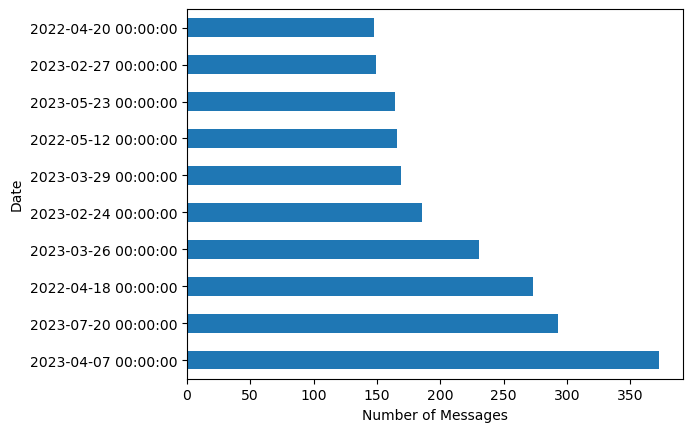

In [34]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

/tmp/ipykernel_29/2454440435.py:7: FutureWarning:

The default value of regex will change from True to False in a future version.



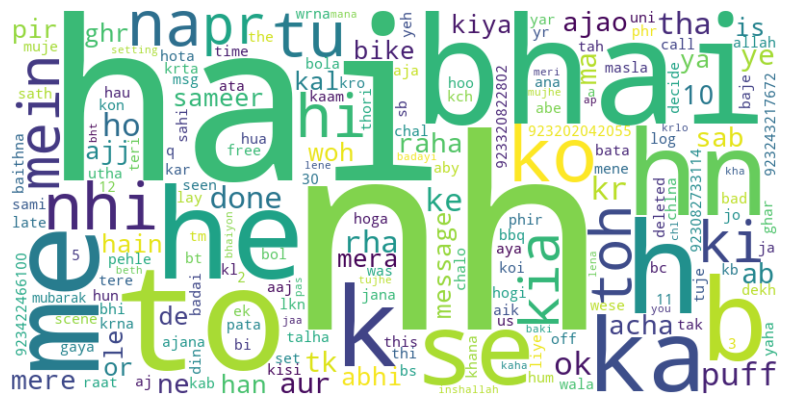

In [35]:
from wordcloud import WordCloud

# Assuming you have a DataFrame called 'messages_df' with a column 'Message' containing the chat messages.

# Step 1: Preprocess the messages (cleaning and tokenization, if needed)
# For example, you can lowercase the text and remove punctuation:
messages_df['Message'] = messages_df['Message'].str.lower().str.replace('[^\w\s]', '')

# Step 2: Count the occurrences of each word
word_counts = messages_df['Message'].str.split(expand=True).stack().value_counts()

# Step 3: Generate a word cloud to visualize the most used words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


/tmp/ipykernel_29/3599237885.py:9: FutureWarning:

The default value of regex will change from True to False in a future version.



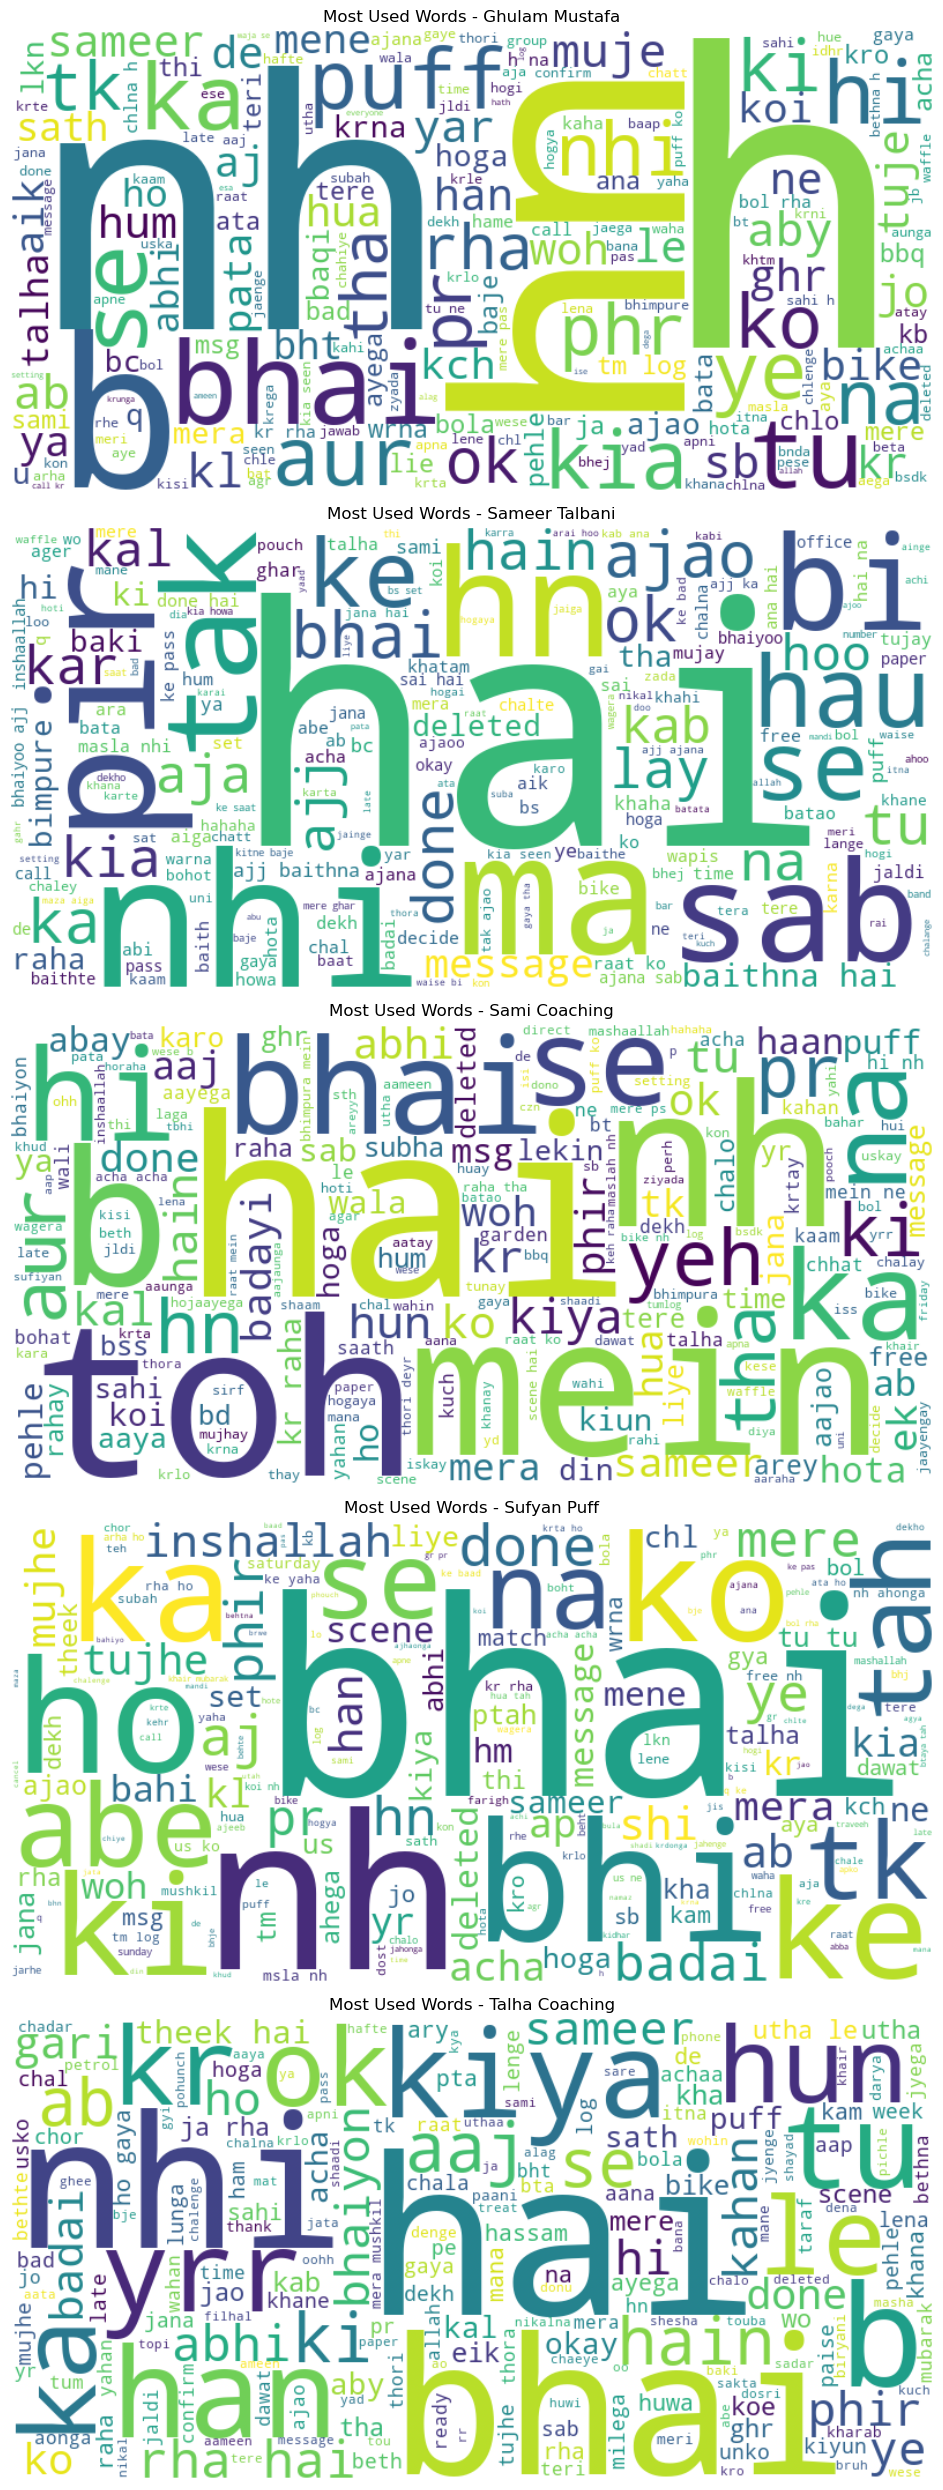

In [36]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'messages_df' with columns 'Author' and 'Message' containing the chat data.

# Step 1: Preprocess the messages (cleaning and tokenization, if needed)
# For example, you can lowercase the text and remove punctuation:
messages_df['Message'] = messages_df['Message'].str.lower().str.replace('[^\w\s]', '')

# Step 2: Group messages by author and concatenate all messages for each author
messages_by_author = messages_df.groupby('Author')['Message'].apply(lambda x: ' '.join(x))

# Step 3: Generate word clouds for each author
num_authors = len(messages_by_author)

plt.figure(figsize=(10, 5*num_authors))

for i, (author, messages) in enumerate(messages_by_author.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_text(messages)

    plt.subplot(num_authors, 1, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Used Words - {author}')
    plt.axis('off')

plt.tight_layout()
plt.show()
